In [46]:
from poke.writing import read_serial_to_rayfront
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from poke.poke_math import eigenvalues_2x2
plt.style.use('bmh')

def proper_retardance(jones):
    e1,e2 = eigenvalues_2x2(jones)
    a1,a2 = np.angle(e1),np.angle(e2)

    greater1mask = a1 > a2
    greater2mask = a2 > a1

    d1 = np.angle(e1)
    d2 = np.angle(e2)

    retardance = np.zeros_like(a1)
    if len(greater1mask[greater1mask==True]) <= 0:
        retardance[greater2mask] = d2 - d1
    elif len(greater2mask[greater2mask==True]) <= 0:
        retardance[greater1mask] = d1 - d2
    else:
        retardance[greater1mask==True] = d1[greater1mask==True] - d2[greater1mask==True]
        retardance[greater2mask==True] = d2[greater2mask==True] - d1[greater2mask==True]

    return retardance

def mean_retardance(jones):
    ret = proper_retardance(jones)
    return np.mean(ret)

def minmax_retardance(jones):
    ret = proper_retardance(jones)
    min = np.min(ret)
    max = np.max(ret)
    return min,max

def rf_mean_retardance(rf):
    jones = rf.jones_pupil[-1][...,:2,:2]
    return mean_retardance(jones)

def rotmat2d(theta):
    jones = np.zeros([2,2])
    cost = np.cos(theta)
    sint = np.sin(theta)
    jones[0,0] = cost
    jones[0,1] = sint
    jones[1,0] = -sint
    jones[1,1] = cost

    return jones

def jones_rotate(matrix,theta):
    return rotmat2d(theta) @ matrix @ rotmat2d(-theta)

In [47]:
# Load poke rayfront
pth = 'rayfronts/k2_orkid_toafm_64rays_633nm.msgpack'
rf = read_serial_to_rayfront(pth)
print(rf.surfaces)

[{'coating': (0.4+7j), 'surf': 1, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 2, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 4, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 10, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 13, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 16, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 20, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 25, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 30, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 33, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 36, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 40, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 43, 'mode': 'reflect'}, {'coating': (0.4+7j), 'surf': 46, 'mode': 'reflect'}]


In [48]:
# Load refractive index data
# create coating splines - dielectrics
pth_SiO2 = 'coatings/Gao_SiO2.csv'
dat_SiO2 = np.genfromtxt(pth_SiO2,delimiter=',',skip_header=1)[:500].T
n_SiO2 = interp1d(dat_SiO2[0],dat_SiO2[1])

pth_CaF2 = 'coatings/Daimon_CaF2.csv'
dat_CaF2 = np.genfromtxt(pth_CaF2,delimiter=',',skip_header=1).T
n_CaF2 = interp1d(dat_CaF2[0],dat_CaF2[1])

pth_SiN = 'coatings/Philipp_SiN.csv'
dat_SiN = np.genfromtxt(pth_SiN,delimiter=',',skip_header=1)[:500].T
n_SiN = interp1d(dat_SiN[0],dat_SiN[1])

pth_MgF2 = 'coatings/Rodriguez-de Marcos_MgF2.csv'
dat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[:962].T
kdat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[964:].T
nd_MgF2 = interp1d(dat_MgF2[0],dat_MgF2[1])
k_MgF2 = interp1d(kdat_MgF2[0],kdat_MgF2[1])
n_MgF2 = lambda wave: nd_MgF2(wave) + 1j*k_MgF2(wave)

# create coating splines - metals
pth_Al = 'coatings/Cheng_Al.csv'
ndat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[:427].T
kdat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[429:].T
nd_Al = interp1d(ndat_Al[0],ndat_Al[1])
k_Al = interp1d(kdat_Al[0],kdat_Al[1])
n_Al = lambda wave: nd_Al(wave) + 1j*k_Al(wave)

pth_Ag = 'coatings/Johnson_Ag.csv'
ndat_Ag = np.genfromtxt(pth_Ag,delimiter=',',skip_header=1)[:50].T
kdat_Ag = np.genfromtxt(pth_Ag,delimiter=',',skip_header=1)[52:].T
nd_Ag = interp1d(ndat_Ag[0],ndat_Ag[1])
k_Ag = interp1d(kdat_Ag[0],kdat_Ag[1])
n_Ag = lambda wave: nd_Ag(wave) + 1j*k_Ag(wave)

In [49]:
# before beamsplitter
a = -np.array([0.9781495997,-0.2079022864,-0.0000000000])
ap = -np.array([0.9854138517,-0.1701750301,-0.0000000000])

# after beamsplitter
# a = np.array([-0.0000016361,-0.0000076972,-1.0000000000])
# ap = np.array([-0.0079881133,-0.0375814411,-0.9992616401]) # PY ray

# AFM
a = np.array([0.9781483265,-0.2079082762,0.0000000000])
ap = np.array([0.9851025210,-0.1719680873,0.0000000000])

a /= np.linalg.norm(a)
ap /= np.linalg.norm(ap)
x = np.cross(a,ap)
x /= np.linalg.norm(x)

# refractive index data
wvl = 0.600 # microns
rf.wavelength = wvl

# Fitted film data, microns
d_SiO2 = 0.159
d_MgF2 = 1.291
d_SiN = 0.124

# coating data
protected_Al = [(n_SiO2(wvl),d_SiO2),(n_Al(wvl))]
protected_Ag = [(n_MgF2(wvl),d_MgF2),(n_Ag(wvl))]
denton_fss99 = [(n_SiN(wvl),d_SiN),(n_Ag(wvl))]
bare_Al = n_Al(wvl)
bare_CaF2 = n_CaF2(wvl).tolist()

# dichroic coatings
ird_retardance = np.pi/2
obs_retardance = np.pi/2

# from heath et al 2020, Table 2 for lambda = 630nm
ird_ret_waves = 0.1
ird_angle = 15 * np.pi/180
ird_coating = np.array([[1,0],[0,np.exp(1j*2*np.pi*ird_ret_waves)]])
ird_coating = jones_rotate(ird_coating,ird_angle)
obs_coating = np.array([[np.exp(1j*2*np.pi*(-0.14)),np.exp(1j*2*np.pi*(-0.41))],
                        [np.exp(1j*2*np.pi*(0.44)),np.exp(1j*2*np.pi*(0.14))]])
obs_coating = jones_rotate(obs_coating,np.pi/2)
obs_coating = np.array([[1,0],[0,1]])
ird_coating = np.array([[1,0],[0,1]])


# set up surfaces
m1 = {'coating':bare_Al,'surf':1,'mode':'reflect'}
m2 = {'coating':bare_Al,'surf':2,'mode':'reflect'}
m3 = {'coating':bare_Al,'surf':4,'mode':'reflect'}

k1 = {'coating':protected_Al,'surf':10,'mode':'reflect'}
k2 = {'coating':denton_fss99,'surf':13,'mode':'reflect'}
k3 = {'coating':protected_Al,'surf':16,'mode':'reflect'}

tt = {'coating':protected_Ag,'surf':20,'mode':'reflect'}
o1 = {'coating':protected_Ag,'surf':25,'mode':'reflect'}
pu = {'coating':denton_fss99,'surf':30,'mode':'reflect'}
o2 = {'coating':protected_Ag,'surf':33,'mode':'reflect'}
ird = {'coating':ird_coating,'surf':36,'mode':'reflect'}

sod = {'coating':bare_CaF2,'surf':40,'mode':'reflect'}
ifm = {'coating':protected_Ag,'surf':43,'mode':'reflect'}
afm = {'coating':protected_Al,'surf':46,'mode':'reflect'}

# fl1 = {'coating':(1,glass),'surf':49,'mode':'transmit'}
# fl2 = {'coating':(glass,1),'surf':50,'mode':'transmit'}

obs = {'coating':obs_coating,'surf':53,'mode':'reflect'}

# od1 = {'coating':(1,glass),'surf':56,'mode':'transmit'}
# od2 = {'coating':(glass,glass*1.1),'surf':57,'mode':'transmit'}
# od3 = {'coating':(1.1*glass,1),'surf':58,'mode':'transmit'}


surflist = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,ird,sod,ifm,afm] # doesn't include lenses
# surflist = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,ird,sod,ifm,afm,fl1,fl2,obs,od1,od2,od3] # doesn't include lenses

rf.surfaces = surflist
rf.compute_jones_pupil(aloc=a,exit_x=x)

In [45]:
# import poke.plotting as plot
jones = rf.jones_pupil[-1][...,:2,:2]

# From Heath et al 2020
obs_coating = np.array([[np.exp(1j*2*np.pi*(-0.14)),np.exp(1j*2*np.pi*(-0.41))],
                        [np.exp(1j*2*np.pi*(0.44)),np.exp(1j*2*np.pi*(0.14))]])
obs_coating = jones_rotate(obs_coating,np.pi/2)
obs_coating = np.broadcast_to(obs_coating,jones.shape)
rf.jones_pupil.append(obs_coating @ jones)

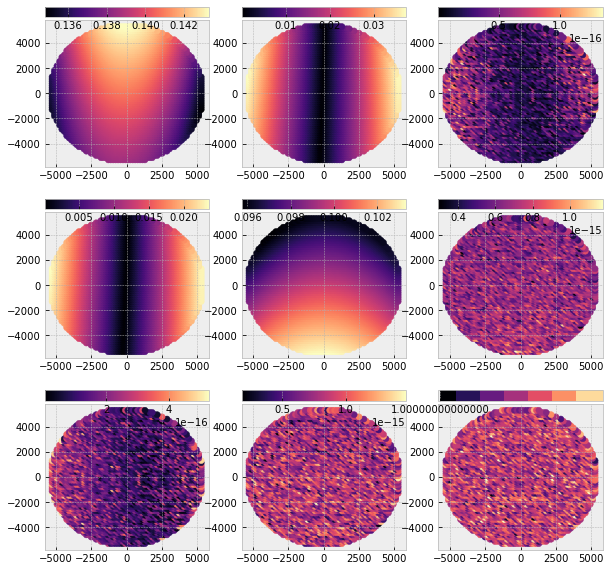

In [50]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

jones = rf.jones_pupil[-1]
xd,yd = rf.xData[0,0],rf.yData[0,0]

def plot_jones_3(jones):

    fig,axs = plt.subplots(ncols=3,nrows=3,figsize=[10,10])
    for i in range(3):
        for j in range(3):
            im = axs[i,j].scatter(xd,yd,c=np.abs(jones[...,i,j]))
            div = make_axes_locatable(axs[i,j])
            cax = div.append_axes("top", size="7%", pad="2%")
            cb = fig.colorbar(im, cax=cax, orientation="horizontal")

    plt.show()

plot_jones_3(jones)

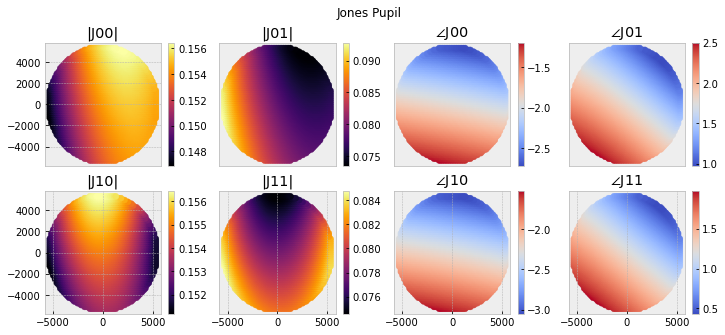

In [41]:
import poke.plotting as plot
# ret = np.pi/2
plot.jones_pupil(rf)

In [51]:
from poke.writing import write_rayfront_to_serial
write_rayfront_to_serial(rf,'rayfronts/k2_orkid_600nm_nobeamsplitters')

In [19]:
nmeas = 32
ird_angles = np.linspace(0,np.pi,nmeas)
obs_angles = np.copy(ird_angles)
meanvals = np.zeros([nmeas,nmeas])
# maxvals = []
# minvals = []
xd,yd = rf.xData[0,0],rf.yData[0,0]
jones_orig = rf.jones_pupil[-1][...,:2,:2]

for i,ird_angle in enumerate(ird_angles):
    for j,obs_angle in enumerate(obs_angles):

        # From Heath et al 2020, 630nm
        dichroic = np.array([[np.exp(1j*2*np.pi*(-0.14)),np.exp(1j*2*np.pi*(-0.41))],
                             [np.exp(1j*2*np.pi*(0.44)),np.exp(1j*2*np.pi*(0.14))]])
        
        # # From Heath et al 2020, 650nm
        # dichroic = np.array([[np.exp(1j*2*np.pi*(-0.23)),np.exp(1j*2*np.pi*(-0.37))],
        #                      [np.exp(1j*2*np.pi*(0.27)),np.exp(1j*2*np.pi*(0.23))]])
        
        # apply the IRD jones matrix
        ird_coating = jones_rotate(dichroic,ird_angle)
        ird = {'coating':ird_coating,'surf':36,'mode':'reflect'}

        rf.surfaces = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,ird,sod,ifm,afm]
        
        # compute the jones pupil
        rf.compute_jones_pupil(aloc=a,exit_x=x)
        jones = rf.jones_pupil[-1][...,:2,:2]
        
        obs_coating = jones_rotate(dichroic,obs_angle)
        obs_coating = np.broadcast_to(obs_coating,jones.shape)
        jones_result = obs_coating @ jones

        meanvals[i,j] = mean_retardance(jones_result)

        # meanvals.append(mean_retardance(jones_result))
        # mins,maxs = minmax_retardance(jones_result)
        # minvals.append(mins)
        # maxvals.append(maxs)
        # rf.jones_pupil.append(jones_result)

        # plt.figure(figsize=[10,5])
        # plt.subplot(121)
        # plt.title('Before Beamsplitter')
        # plt.scatter(xd,yd,c=proper_retardance(jones),cmap='RdBu_r')
        # plt.colorbar()
        # plt.subplot(122)
        # plt.title('After Beamsplitter')
        # plt.scatter(xd,yd,c=proper_retardance(jones_result),cmap='RdBu_r')
        # plt.colorbar()
        # plt.show()
            
        # plot.jones_pupil(rf)
rf.jones_pupil.append(jones_orig)

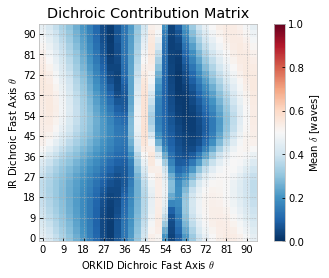

In [20]:
# plot the dichroic contribution matrix
ticks = np.arange(0,33,3) 
ticklabels = np.linspace(0,90,len(ticks))
tickstr = [int(tick) for tick in ticklabels]
fig,ax = plt.subplots()
ax.set_title('Dichroic Contribution Matrix')
ax.set_xlabel('ORKID Dichroic Fast Axis '+r'$\theta$')
ax.set_xticks(ticks)
ax.set_xticklabels(tickstr)
ax.set_yticks(ticks)
ax.set_yticklabels(tickstr)
ax.set_ylabel('IR Dichroic Fast Axis '+r'$\theta$')
im = ax.imshow(meanvals/2/np.pi,cmap='RdBu_r',vmin=0,vmax=1)
fig.colorbar(im,ax=ax,label='Mean '+r'$\delta$'+' [waves]')
plt.show()


NameError: name 'angles' is not defined

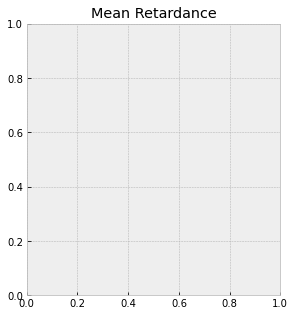

In [9]:
rad2deg = 180/np.pi
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Mean Retardance')
plt.plot(angles*rad2deg,[meanv/(2*np.pi) for meanv in meanvals],label='Mean')
plt.ylabel('Retardance [waves]')
plt.xlabel('Dichroic fast axis angle [deg]')
plt.xlim([0,180])
plt.subplot(122)
plt.title('Mean-subtracted Min and Max retardanc')
plt.plot(angles*rad2deg,[(maxv - meanv)/(2*np.pi) for maxv,meanv in zip(maxvals,meanvals)],label='max')
plt.plot(angles*rad2deg,[(minv - meanv)/(2*np.pi) for minv,meanv in zip(minvals,meanvals)],label='min')
plt.plot(angles*rad2deg,np.zeros_like(angles),linestyle='dashed',color='black')
plt.xlabel('Dichroic fast axis angle [deg]')
plt.legend()
plt.ylim([-1/4,1/4])
plt.xlim([0,180])
plt.show()

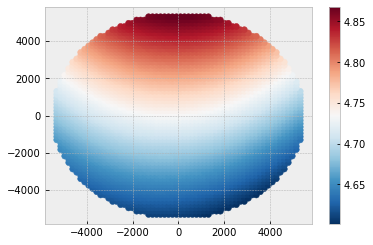

In [ ]:
jones = rf.jones_pupil[-5][...,:2,:2]
xd,yd = rf.xData[0,0],rf.yData[0,0]
e1,e2 = eigenvalues_2x2(jones)
plt.figure()
plt.scatter(xd,yd,c=proper_retardance(jones),cmap='RdBu_r')
plt.colorbar()
plt.show()